In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn import metrics
from math import sqrt
from sklearn.model_selection import train_test_split
import missingno as msno

df = pd.read_csv('result.csv')
rows_drop = []
for index,row in df.iterrows():
    if row[2:].isnull().sum()/len(row[2:])>0.5:
        rows_drop.append(index)
df_new = df.drop(rows_drop,axis=0)

tmp = df_new.drop(['region_name','date'],axis=1)

cols_drop = []
for col in tmp[0:0]:
    if df_new[col].isnull().sum()/180>0.5:
        cols_drop.append(col)
df_new = df_new.drop(cols_drop,axis=1)
df_new = df_new.fillna(0)
df = df_new
region = df.region_name.unique()

def split_region(i):
    val_state = np.array([region[2*i], region[2*i+1]])
    train = df.loc[~np.in1d(df['region_name'], val_state)]
    val = df.loc[np.in1d(df['region_name'], val_state)]
    return (train, val)

def cross_val(neigh,typ):
    score_list_cv = []
    
    if typ == "region":
        for i in range(0,3):
            train, val = split_region(i)
            x_train = train.iloc[:,2:-1]
            y_train = train.iloc[:, -1]
            x_val = val.iloc[:,2:-1]
            y_val = val.iloc[:,-1] 
    
            neigh.fit(x_train, y_train)
            y_pred = neigh.predict(x_val)
            score_list_cv.append(sqrt(metrics.mean_squared_error(y_val,y_pred)))
        return np.average(score_list_cv)
    
    elif typ == "time":
        for i in range(0,2):
            if i == 0:
                train = df.loc[df['date'] < '2020-08-10']
                val = df.loc[df['date'] >= '2020-08-10']
            else:
                train = df.loc[df['date'] >= '2020-08-10']
                val = df.loc[df['date'] < '2020-08-10']
            
            x_train = train.iloc[:,2:-1]
            y_train = train.iloc[:, -1]
            x_val = val.iloc[:,2:-1]
            y_val = val.iloc[:,-1] 
        
            neigh.fit(x_train, y_train)
            y_pred = neigh.predict(x_val)
            score_list_cv.append(sqrt(metrics.mean_squared_error(y_val,y_pred)))
        return np.average(score_list_cv)
        
    return 0


29.28517929924689
[35.839626940236236, 34.5825394906976, 34.032250807432185, 33.576050007918575, 32.6346689582386, 32.198964853690846, 31.736023269369458, 31.774229103442195, 31.562989173074556, 31.60191029543036, 31.51969308292345, 31.37107678242206, 31.440272815808797, 31.45556881795766, 31.32657294316782, 31.146941962947775, 31.127498569297547, 31.072976658260263, 30.808980144605002, 30.820122258056845, 30.871356234466315, 30.928120207794937, 30.82136721893578, 30.763727272026586, 30.79638872986348, 30.726743797211938, 30.531821931254058, 30.43091214634467, 30.28685046732993, 30.08400279955733, 30.088473588898726, 30.000126671220897, 29.904695253804306, 29.83391411798128, 29.798022256982193, 29.71635361378634, 29.64957563912013, 29.57893734092993, 29.502829948185404, 29.432976586764664, 29.421150903753926, 29.418052455024952, 29.338650295429318, 29.28517929924689, 29.33579552613064, 29.304862876438648, 29.34439180835986, 29.393733918558155, 29.487550327792803, 29.52355344879258, 29.

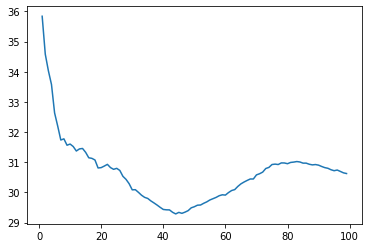

In [2]:
score_list = []
for k in range(1,100):
    score_list.append(cross_val(KNN(k),"region"))

print(min(score_list))
print(score_list)
plt.plot(range(1,100),score_list)

print(min(score_list))
print(score_list)

30.969018277634564
[32.5814161578292, 32.53731027463821, 32.69549254489714, 31.364475312268087, 34.72182867815064, 30.969018277634564, 33.285935516144846, 33.43106521281901, 33.79590160459449, 32.5882241279209, 32.27816723701932, 32.27816723701932, 32.27816723701932, 32.27816723701932, 32.27816723701932, 32.27816723701932, 32.27816723701932]


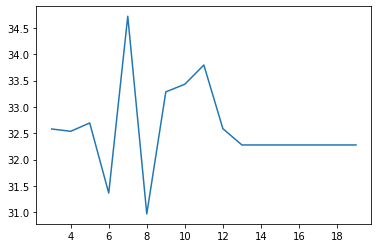

In [3]:
score_list = []
for k in range(3,20):
    #score_list.append(cross_val(DTR(max_depth=k)))
    score_list.append(cross_val(DTR(max_depth=k,random_state=10),"region"))
    
print(min(score_list))
print(score_list)
plt.plot(range(3,20),score_list)

34.06825104630077
[34.42117258651946, 34.090742984516446, 34.59406065182011, 34.35685087551893, 34.711740125923605, 35.37033836357083, 34.893075365966425, 34.54462143828386, 34.33902017741811, 34.43041904814159, 34.06825104630077, 34.18252529710108, 34.179415038917995, 34.715354262340895, 34.807137660208994, 34.695500890568695, 34.63050363165392]


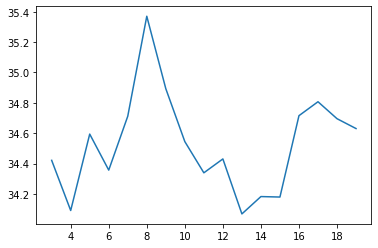

In [4]:
score_list = []
for k in range(3,20):
    score_list.append(cross_val(KNN(k),"time"))

print(min(score_list))
print(score_list)
plt.plot(range(3,20),score_list)

33.359124230598894
[35.43197823644677, 36.04826503562785, 33.359124230598894, 33.424679364288494, 34.007529643260156, 34.04340060118194, 33.47500009255101, 37.298465276466864, 37.31627728545507, 37.30792898399115, 37.30792898399115, 37.30792898399115, 37.30792898399115, 37.30792898399115, 37.30792898399115, 37.30792898399115, 37.30792898399115]


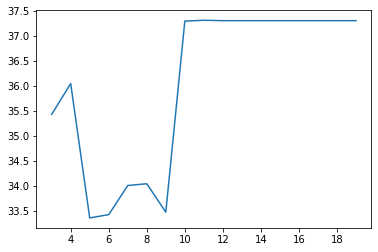

In [5]:
score_list = []
for k in range(3,20):
    #score_list.append(cross_val(DTR(max_depth=k)))
    score_list.append(cross_val(DTR(max_depth=k,random_state=10),"time"))
    
print(min(score_list))
print(score_list)
plt.plot(range(3,20),score_list)

31.42398234894277


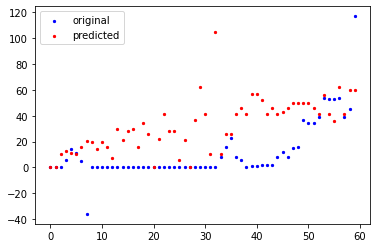

In [6]:
knn = KNN(2)

train, val = split_region(0)
knn.fit(train.iloc[:,3:-1], train.iloc[:,-1])
pred = knn.predict(val.iloc[:,3:-1])

print(sqrt(metrics.mean_squared_error(val.iloc[:,-1],pred)))

plt.scatter(range(len(val.iloc[:,-1])), val.iloc[:,-1], s=5, color="blue", label="original")
plt.scatter(range(len(val.iloc[:,-1])), pred, s=5, color="red", label="predicted")
plt.legend()
plt.show()


In [7]:
'''
df = pd.read_csv('result.csv')
rows_drop = []
for index,row in df.iterrows():
    if row[2:].isnull().sum()/len(row[2:])>0.5:
        rows_drop.append(index)
df_new = df.drop(rows_drop,axis=0)

tmp = df_new.drop(['region_name','date'],axis=1)

cols_drop = []
for col in tmp[0:0]:
    if df_new[col].isnull().sum()/180>0.5:
        cols_drop.append(col)
df_new = df_new.drop(cols_drop,axis=1)
df_new.to_csv('result_new.csv', index=False)
'''

#msno.matrix(df, labels=True)
#msno.matrix(df_new, labels=True)

"\ndf = pd.read_csv('result.csv')\nrows_drop = []\nfor index,row in df.iterrows():\n    if row[2:].isnull().sum()/len(row[2:])>0.5:\n        rows_drop.append(index)\ndf_new = df.drop(rows_drop,axis=0)\n\ntmp = df_new.drop(['region_name','date'],axis=1)\n\ncols_drop = []\nfor col in tmp[0:0]:\n    if df_new[col].isnull().sum()/180>0.5:\n        cols_drop.append(col)\ndf_new = df_new.drop(cols_drop,axis=1)\ndf_new.to_csv('result_new.csv', index=False)\n"

28.332229087820693
[45.13428059898428, 36.63584443770602, 31.43689492341841, 30.8324430699444, 30.737916919799105, 29.99682608434377, 28.893297907096596, 29.104403601493075, 28.885503851310546, 28.332229087820693, 28.754680357715937, 29.59568239289909, 29.820262890363768, 30.16012279130142, 29.866906868320303, 30.06538671334972, 29.958675185020684, 29.734482057748277, 30.236322292529376]


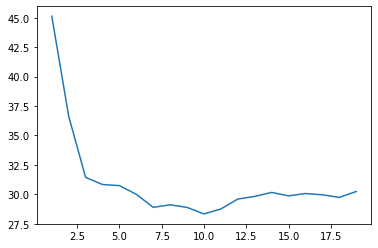

In [8]:
from sklearn.ensemble import RandomForestRegressor as RFR
score_list = []
for k in range(1,20):
    score_list.append(cross_val(RFR(k,random_state=10),"region"))

print(min(score_list))
print(score_list)
plt.plot(range(1,20),score_list)

31.202945268509602
[39.66845296442135, 34.631021339240974, 32.15799821980888, 31.202945268509602, 32.128145853138236, 32.660330866532846, 32.02216261455313, 32.22452449675867, 32.35846475151571, 33.833554532242694, 33.7794177384721, 33.64554940984638, 33.46241211201085, 33.366495488471514, 33.099835305724085, 33.00964566587598, 33.006906538561175, 32.97614668594139, 33.250772127774525]


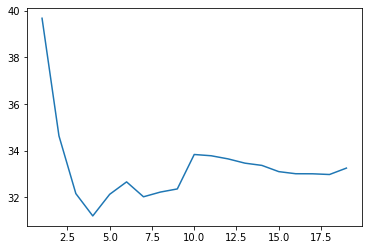

In [9]:
from sklearn.ensemble import RandomForestRegressor as RFR
score_list = []
for k in range(1,20):
    score_list.append(cross_val(RFR(k,random_state=10),"time"))

print(min(score_list))
print(score_list)
plt.plot(range(1,20),score_list)